In [2]:
__imp

Libraries have been loaded


## Load Additional Libraries

In [3]:
%reload_ext Cython
import multiprocessing as mp

basepath = os.path.expanduser('../')

## Load Data

In [6]:
%%time

app_train = pd.read_feather(os.path.join(basepath, 'data/processed/application_train.feather'))
app_test  = pd.read_feather(os.path.join(basepath, 'data/processed/application_test.feather'))

bureau    = pd.read_feather(os.path.join(basepath, 'data/processed/bureau.feather'))
prev_app  = pd.read_pickle(os.path.join(basepath, 'data/processed/prev_app.pkl'))

CPU times: user 192 ms, sys: 202 ms, total: 394 ms
Wall time: 394 ms


In [47]:
%%time

tr = app_train.loc[:, ['SK_ID_CURR']].merge(prev_app.loc[:, ['SK_ID_CURR', 'DAYS_DECISION']],
                                            on='SK_ID_CURR',
                                            how='left'
                                           )

te = app_test.loc[:, ['SK_ID_CURR']].merge(prev_app.loc[:, ['SK_ID_CURR', 'DAYS_DECISION']],
                                           on='SK_ID_CURR',
                                           how='left'
                                          )

CPU times: user 516 ms, sys: 0 ns, total: 516 ms
Wall time: 519 ms


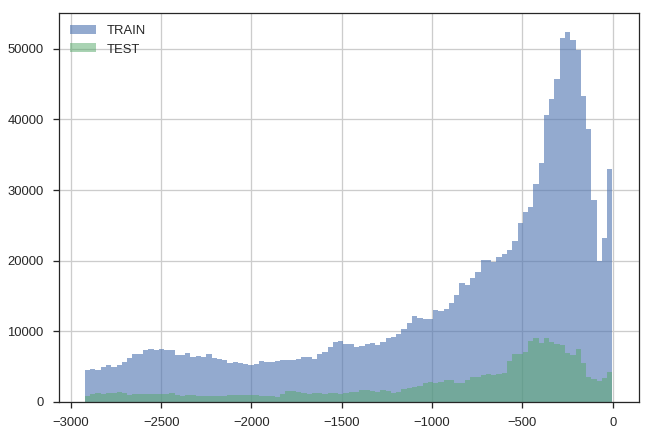

In [50]:
tr.DAYS_DECISION.hist(bins=100, alpha=.6, label='TRAIN')
te.DAYS_DECISION.hist(bins=100, alpha=.5, label='TEST')
plt.legend(loc='best');

In [14]:
%%time

tr = bureau.loc[:, ['SK_ID_CURR', 'SK_ID_BUREAU', 'DAYS_ENDDATE_FACT']]\
           .merge(prev_app.loc[:, ['SK_ID_CURR', 'DAYS_DECISION']], how='left')

CPU times: user 687 ms, sys: 299 ms, total: 986 ms
Wall time: 991 ms


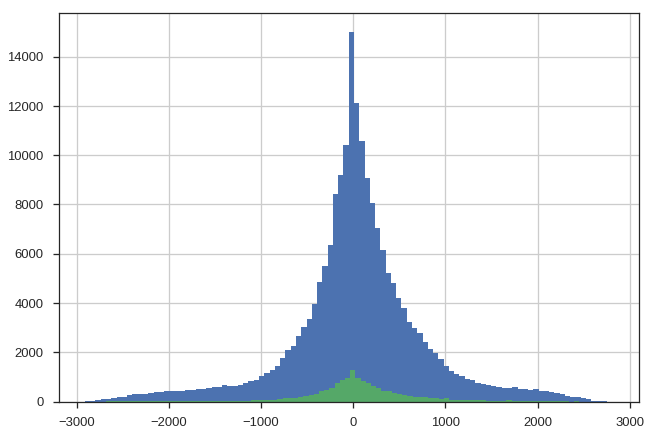

In [21]:
res = tr.groupby('SK_ID_CURR')[['DAYS_ENDDATE_FACT', 'DAYS_DECISION']].max()
res = res.DAYS_DECISION - res.DAYS_ENDDATE_FACT
res = app_train.SK_ID_CURR.map(res)

res[(app_train.TARGET == 0)].hist(bins=100)
res[(app_train.TARGET == 1)].hist(bins=100);